In [2]:
import pandas as pd
import tensorflow as tf
import alibi
import torch.nn as nn
from alibi_detect.cd import ClassifierDrift
from alibi_detect.cd.pytorch import preprocess_drift
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from alibi_detect.cd import MMDDriftOnline
from alibi_detect.cd import MMDDrift

2021-12-03 16:47:38.388234: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-03 16:47:38.389078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 16:47:38.389884: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
data = pd.read_csv('/mnt/nfs/project/delirium/data/all_before_2018.csv')
data_2019 = pd.read_csv('/mnt/nfs/project/delirium/data/data_2019.csv')
data_2020 = pd.read_csv('/mnt/nfs/project/delirium/data/data_2020.csv')

In [4]:
features= ['sex', 'age', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'los_er', 'icd10_A00_B99',
       'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99',
       'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99',
       'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99',
       'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99',
       'icd10_S00_T88', 'icd10_Z00_Z99', 'icd10_nan']

In [5]:
data[features] = data[features].fillna(0)
data_2019[features] = data_2019[features].fillna(0)
data_2020[features] = data_2020[features].fillna(0)

In [6]:
data[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281565 entries, 0 to 281564
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sex             281565 non-null  int64  
 1   age             281565 non-null  int64  
 2   mort_hosp       281565 non-null  int64  
 3   readmission_7   281565 non-null  int64  
 4   readmission_28  281565 non-null  int64  
 5   palliative      281565 non-null  int64  
 6   los_er          281565 non-null  float64
 7   icd10_A00_B99   281565 non-null  int64  
 8   icd10_C00_D49   281565 non-null  int64  
 9   icd10_D50_D89   281565 non-null  int64  
 10  icd10_E00_E89   281565 non-null  int64  
 11  icd10_F01_F99   281565 non-null  int64  
 12  icd10_G00_G99   281565 non-null  int64  
 13  icd10_H00_H59   281565 non-null  int64  
 14  icd10_H60_H95   281565 non-null  int64  
 15  icd10_I00_I99   281565 non-null  int64  
 16  icd10_J00_J99   281565 non-null  int64  
 17  icd10_K00_

In [7]:
x_tr = data[features].values.astype('float32')
x_ref = data_2019[features].values.astype('float32')
x_d= data_2020[features].values.astype('float32')

In [8]:
#tr_slices = [2006, 2008,2009, 2010, 2011, 2012, 2013, 2014,2015]
#ref_slices = [2016]
#eval_slices = [2017]
#x_tr = data.loc[data['year'].isin(tr_slices)][features].values.astype('float32')
#x_ref = data.loc[data['year'].isin(ref_slices)][features].values.astype('float32')
#x_d= data.loc[data['year'].isin(eval_slices)][features].values.astype('float32')

## using PCA for dimensional reduction and pre-processing

In [9]:
pca = PCA(2)
pca.fit(x_tr)
x_ref_2 = pca.transform(x_ref)
x_d_2 = pca.transform(x_d)

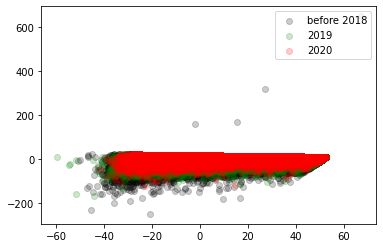

In [10]:
plt.scatter(pca.transform(x_tr)[:,0], pca.transform(x_tr)[:,1], alpha=0.2, color='black', label='before 2018')
plt.scatter(x_ref_2[:,0], x_ref_2[:,1], alpha=0.2, color='green', label='2019')
plt.scatter(x_d_2[:,0], x_d_2[:,1], alpha=0.2, color='red', label='2020')
plt.legend(loc='upper right')
plt.show()

In [11]:
cd = MMDDrift(x_ref[:100,:], backend='pytorch', preprocess_fn=pca.transform)

No GPU detected, fall back on CPU.


In [12]:
pred = cd.predict(x_d[:100,:])
if pred['data']['is_drift'] == 1:
    print ('drift detected')

## using other models such as deep learning for dimensionality reduction and pre-processing

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dim = x_tr.shape[-1]
model = nn.Sequential(
        nn.Linear(data_dim, 16),
        nn.SiLU(),
        nn.Linear(16, 8),
        nn.SiLU(),
        nn.Linear(8, 1),
).to(device)

In [14]:
from functools import partial
preprocess_fn = partial(preprocess_drift, model=model, device=device, batch_size=512)

In [15]:
cd = MMDDrift(x_ref[:100,:], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)


No GPU detected, fall back on CPU.


In [16]:
pred = cd.predict(x_d[:100,:])
if pred['data']['is_drift'] == 1:
    print ('drift detected')
else:
    print ('no drift is detected')

no drift is detected
